<a href="https://colab.research.google.com/github/Lucas-Monteiro-Henriques/Implement_VISIONTS/blob/main/MAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importei MAE do Facebook

In [35]:
import numpy as np
import pandas as pd
import sys
import os
import subprocess
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from skimage.transform import resize
import urllib.request


import torch
import timm
from timm.models.vision_transformer import PatchEmbed, Block
np.float = float

import matplotlib.pyplot as plt
from PIL import Image

In [36]:
repo_dir = 'mae'
repo_url = 'https://github.com/facebookresearch/mae.git'

if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    if not os.path.exists('mae'):
        !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    if not os.path.exists(repo_dir):
        print(f'Cloned in : {repo_dir}')
        subprocess.run(['git', 'clone', repo_url], check=True)
    else:
        print(f'Repository already exists in {repo_dir}')

Running in Colab.


In [37]:
if os.path.exists('pytorch_image_models'):
    pass
else:
    !git clone https://github.com/huggingface/pytorch-image-models.git
    os.rename('pytorch-image-models', 'pytorch_image_models') #renomeia a pasta porque dá conflito nos imports


In [38]:
# from pytorch_image_models.timm.models.vision_transformer import PatchEmbed, Block

In [39]:
mae_path = os.path.abspath("mae")
if mae_path not in sys.path:
    sys.path.insert(0, mae_path)

from models_mae import mae_vit_base_patch16

In [40]:
model = mae_vit_base_patch16()

Implementação do Algoritmo de transformação das séries temporais 1D para 2D

In [41]:
df = pd.read_csv("https://github.com/zhouhaoyi/ETDataset/raw/main/ETT-small/ETTm1.csv")


serie = serie = df["OT"].values[:512]

acf_vals = acf(serie, nlags=min(50, len(serie)//2), fft=True)

lags = np.arange(1, len(acf_vals))
acf_sem_lag0 = acf_vals[1:]
peaks, _ = find_peaks(acf_sem_lag0, height=0.2)

if len(peaks) == 0:
    P = 1
else:
    P = peaks[0] + 1

print(f"Periodicidade estimada: {P}")

L = (len(serie) // P) * P
serie_cortada = serie[:L]


matriz_2d = serie_cortada.reshape(P, L // P)
print("Matriz 2D:\n", matriz_2d)

Periodicidade estimada: 29
Matriz 2D:
 [[30.53100014 30.45999908 30.03800011 27.01300049 27.78700066 27.71699905
  27.64599991 27.08399963 27.78700066 27.50600052 27.85700035 27.01300049
  25.04400063 24.5510006  23.56599998 21.52599907 21.94799995]
 [21.45599937 22.79199982 21.0340004  21.17399979 20.82299995 21.17399979
  21.17399979 22.79199982 23.84799957 24.34000015 23.1439991  23.1439991
  23.77700043 23.84799957 23.98800087 21.66699982 22.0890007 ]
 [22.37000084 16.39100075 17.44599915 17.72699928 18.50099945 19.27499962
  19.97900009 18.50099945 18.5720005  19.41600037 20.11899948 19.76799965
  19.76799965 20.32999992 19.20499992 17.72699928 18.6420002 ]
 [18.50099945 18.5720005  19.6970005  19.55599976 19.83799934 19.55599976
  19.41600037 19.13400078 17.02400017 17.30500031 18.78300095 18.85300064
  19.20499992 19.48600006 19.62700081 18.43099976 19.76799965]
 [19.13400078 20.75200081 19.76799965 20.68199921 20.68199921 19.83799934
  19.20499992 19.41600037 18.71199989 17.868

Normalization do Iraw


In [42]:
import numpy as np
from statistics import mean
desvio_padrao = np.std(matriz_2d)
print(desvio_padrao)
mean  = np.mean(matriz_2d)
print(mean)

4.647547551956378
25.519399588780278


In [43]:
r = 0.4
Inorm = r * (matriz_2d - mean)/ desvio_padrao
print(Inorm)

[[ 0.43133291  0.42522207  0.38890193  0.1285496   0.19516539  0.18914057
   0.18302989  0.13466027  0.19516539  0.17098058  0.20119005  0.1285496
  -0.04091611 -0.0833471  -0.16812304 -0.34369959 -0.30737929]
 [-0.34972425 -0.23473884 -0.38604439 -0.37399508 -0.40420455 -0.37399508
  -0.37399508 -0.23473884 -0.14385221 -0.10150725 -0.20444335 -0.20444335
  -0.14996289 -0.14385221 -0.13180274 -0.3315641  -0.29524379]
 [-0.27105898 -0.78565297 -0.69485253 -0.67066772 -0.60405193 -0.53743613
  -0.476845   -0.60405193 -0.59794109 -0.52530064 -0.46479568 -0.49500515
  -0.49500515 -0.44663553 -0.54346079 -0.67066772 -0.59191643]
 [-0.60405193 -0.59794109 -0.50111583 -0.51325132 -0.48898049 -0.51325132
  -0.52530064 -0.54957147 -0.73117267 -0.70698786 -0.57978093 -0.57375628
  -0.54346079 -0.51927598 -0.50714048 -0.61007658 -0.49500515]
 [-0.54957147 -0.41031522 -0.49500515 -0.41634004 -0.41634004 -0.48898049
  -0.54346079 -0.52530064 -0.58589177 -0.65853222 -0.62823674 -0.60405193
  -0.6585

Esse é o algorimo do Alignment, mas não foi testado, pois o MAE do Facebook precisa ser alterado na parte da mascara


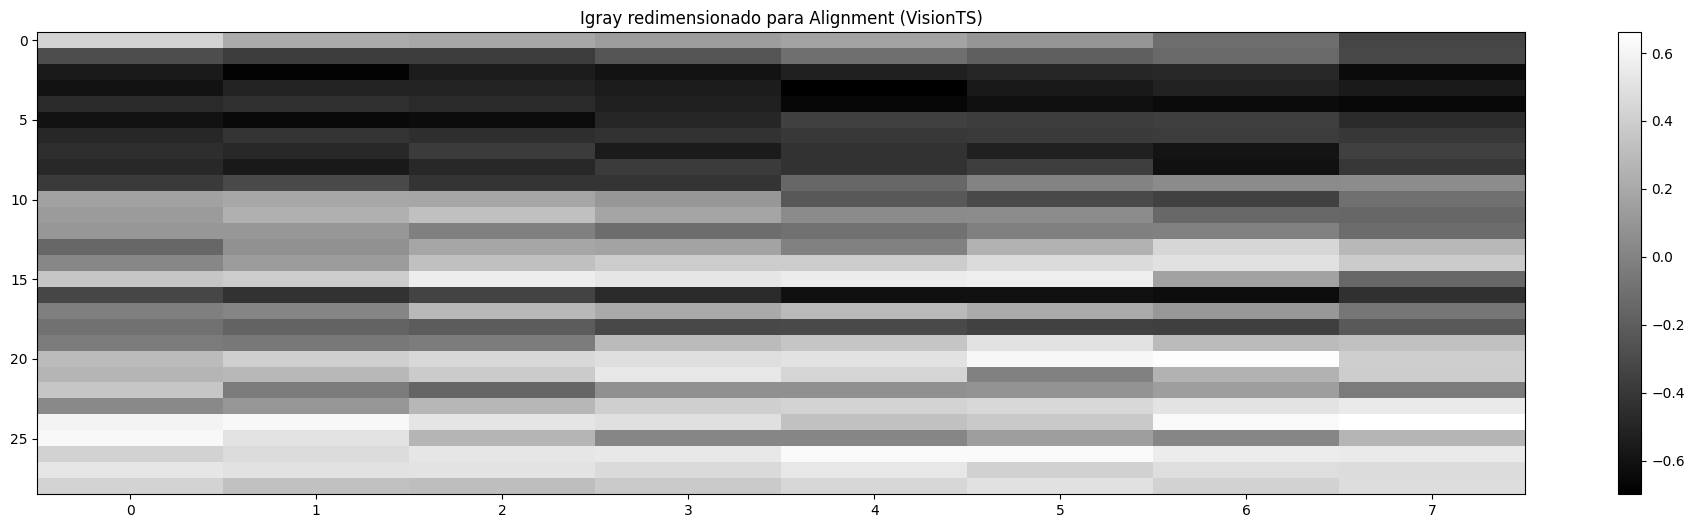

Shape original Inorm: (29, 17)
Shape Igray: (29, 17, 3)
Shape Igray_resized: (29, 8)
Shape Igray_resized_3ch: (29, 8, 3)


In [44]:
L = 300
H = 100
c = 0.4
S = 1
N = max(Inorm.shape)

# Etapa 1: Render Igray (imagem 3 canais iguais)
Igray = np.stack([Inorm] * 3, axis=-1)

# Etapa 2: Alignment
n = int(np.floor(c * N * L / (L + H)))  # número de patches visíveis na horizontal
target_shape = (N * S, n * S)           # shape final da imagem após resize

# Resize Igray (mantendo apenas 1 canal para simplificar o MAE)
Igray_resized = resize(Inorm, target_shape, order=1, mode='reflect', anti_aliasing=False)

# Converter para imagem 3 canais (opcional, dependendo do input do MAE)
Igray_resized_3ch = np.stack([Igray_resized] * 3, axis=-1)

# Visualização
plt.imshow(Igray_resized, cmap='gray', aspect='auto')
plt.title("Igray redimensionado para Alignment (VisionTS)")
plt.colorbar()
plt.show()

# Print das formas para verificação
print("Shape original Inorm:", Inorm.shape)
print("Shape Igray:", Igray.shape)
print("Shape Igray_resized:", Igray_resized.shape)
print("Shape Igray_resized_3ch:", Igray_resized_3ch.shape)


Funções do MAE

In [45]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    from models_mae import mae_vit_base_patch16
    model = mae_vit_base_patch16()

    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image_from_aligned_image(Igray_resized_3ch, model, L=300, H=100, c=0.4):
    """
    Igray_resized_3ch: imagem com 3 canais (já alinhada), shape (H, W, 3), valores já normalizados
    model: modelo MAE do repo da Meta (Vit-base etc)
    L, H, c: hiperparâmetros do VisionTS
    """
    # 1. Redimensionar para 224x224 (como esperado pelo MAE)
    img = resize(Igray_resized_3ch, (224, 224), order=1, mode='reflect', anti_aliasing=False)
    x = torch.tensor(img, dtype=torch.float32).unsqueeze(0)       # [1, H, W, C]
    if False:
        x = torch.einsum('nhwc->nchw', x).cuda()                      # [1, 3, 224, 224]
    if True:
        x = torch.einsum('nhwc->nchw', x).to(device)

    # 2. Criar máscara estruturada: lado direito mascarado
    patch_size = model.patch_embed.patch_size[0]         # geralmente 16
    num_patches_row = x.shape[2] // patch_size           # 224 / 16 = 14
    num_patches = num_patches_row ** 2                   # 14 x 14 = 196

    N = num_patches_row
    n = int(np.floor(c * N * L / (L + H)))                # número de colunas visíveis

    # Criar máscara: 0 = visível (esquerda), 1 = mascarado (direita)
    mask = torch.ones(num_patches, device=x.device)
    for row in range(N):
        for col in range(n):  # colunas visíveis
            idx = row * N + col
            mask[idx] = 0
    mask = mask.unsqueeze(0)  # [1, num_patches]

    # 3. Forward com máscara estruturada
    with torch.no_grad():
        if False:
            loss, y, _ = model(x.float(), mask=mask)         # usamos mask diretamente
        if True:
            loss, y, _ = model(x.float())
        y = model.unpatchify(y)                          # [1, 3, H, W]
        if False:
            y = torch.einsum('nchw->nhwc', y).cpu().numpy()
        if True:
            y = torch.einsum('nchw->nhwc', y).cpu()

        mask_recon = mask.unsqueeze(-1).repeat(1, 1, patch_size ** 2 * 3)
        mask_recon = model.unpatchify(mask_recon)
        mask_recon = torch.einsum('nchw->nhwc', mask_recon).cpu()

    x_vis = x.cpu()
    x_vis = torch.einsum('nchw->nhwc', x_vis)

    im_masked = x_vis * (1 - mask_recon)
    im_paste = x_vis * (1 - mask_recon) + y * mask_recon

    # 4. Visualização
    plt.rcParams['figure.figsize'] = [24, 6]
    plt.subplot(1, 4, 1); show_image(x_vis[0], "original")
    plt.subplot(1, 4, 2); show_image(im_masked[0], "structured mask")
    plt.subplot(1, 4, 3); show_image(y[0], "reconstruction")
    plt.subplot(1, 4, 4); show_image(im_paste[0], "reconstruction + visible")
    plt.show()

    return y[0]  # retorno da imagem reconstruída (H, W, 3)


Vizulização da imagem

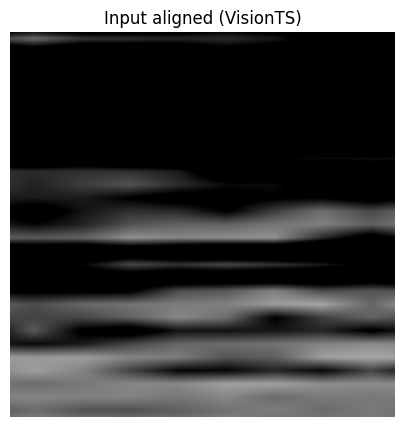

In [46]:
# Suponha que você já tem:
# Igray_resized_3ch com shape (29, 8, 3) — imagem com 3 canais e normalizada (VisionTS-style)

# Etapa 1: Redimensionar para 224 x 224 (como esperado pelo MAE)
img = resize(Igray_resized_3ch, (224, 224), order=1, mode='reflect', anti_aliasing=False)

# Etapa 2: Visualização opcional (sem normalizar com ImageNet)
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(img)
plt.title("Input aligned (VisionTS)")
plt.axis('off')
plt.show()

# Se for usar a função run_one_image, ela espera um tensor com valores normalizados já
# Portanto você pode usar:
img = torch.tensor(img, dtype=torch.float32)


Download dos pesos de Modelo


In [47]:
# MAE com decoder
if False:
    !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth

if True:
    url = 'https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth'
    dest = 'mae_visualize_vit_base.pth'

    if not os.path.exists(dest):
        print('Downloading MAE with decoder...')
        urllib.request.urlretrieve(url, dest)
    else:
        pass


In [48]:
# Carrega o modelo base

from models_mae import mae_vit_base_patch16

chkpt_dir = 'mae_visualize_vit_base.pth'
model = mae_vit_base_patch16()
checkpoint = torch.load(chkpt_dir, map_location='cpu')
msg = model.load_state_dict(checkpoint['model'], strict=False)
print(msg)

# Enviar para GPU
model.eval()
# model.cuda()

<All keys matched successfully>


MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_features=768, out_features=512, bias=

MAE with pixel reconstruction:


/tmp/ipython-input-45-4057300009.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


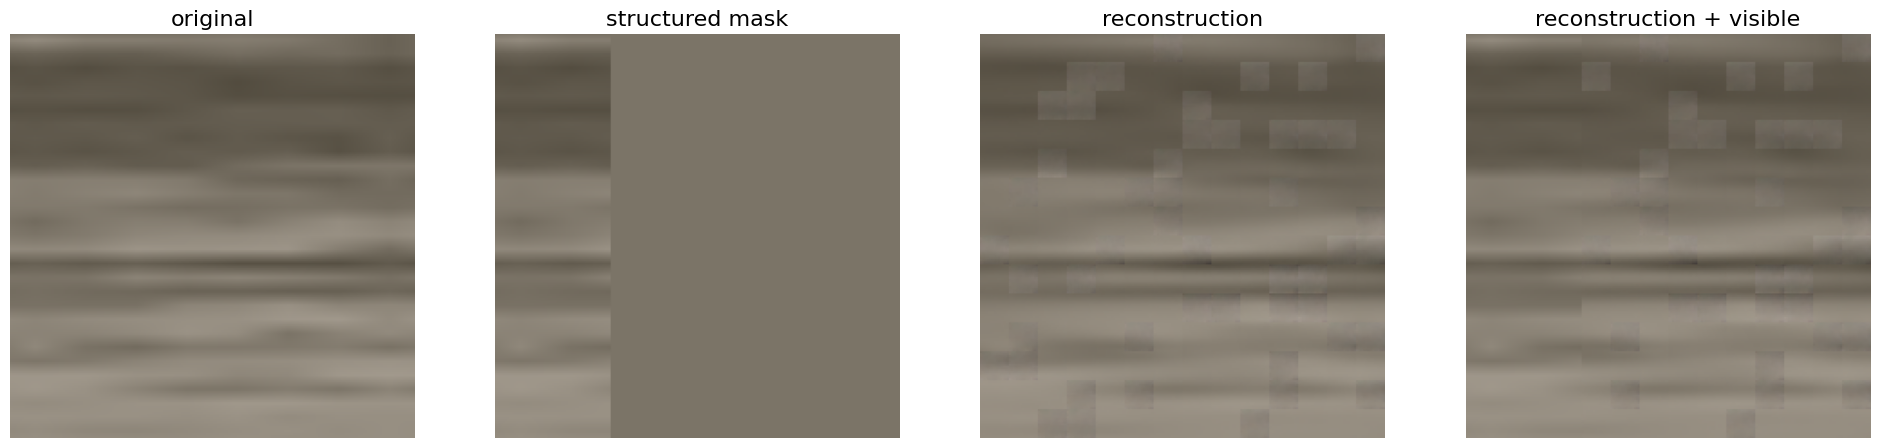

In [49]:
# make random mask reproducible (comment out to make it change)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # usa cuda ou cpu
model = model.to(device)

# Garante reprodutibilidade na máscara aleatória
torch.manual_seed(2)

Igray_resized_3ch_tensor = torch.from_numpy(Igray_resized_3ch).float().to(device)
print('MAE with pixel reconstruction:')
reconstructed_image = run_one_image_from_aligned_image(Igray_resized_3ch, model)


Algoritmo de reconstrução, mas ele está funcionando somente com a mascara aleatória do MAE do facebook, ou seja, ele não usa o Alignment do artigo

In [64]:
def reconstruct_and_evaluate_forecast(y_reconstructed, original_Inorm):
    """
    y_reconstructed: imagem reconstruída pelo MAE, shape (H, W, 3)
    original_Inorm: matriz 2D usada originalmente, shape (P, L/P)
    r: fator de normalização aplicado
    """
    r = 0.4
    import numpy as np
    from skimage.transform import resize
    from sklearn.metrics import mean_squared_error

    # Etapa 1: média dos 3 canais para obter imagem grayscale reconstruída
    recon_gray = y_reconstructed.mean(axis=-1)  # shape (H, W)

    # Etapa 2: resize reverso para shape original
    recon_resized_back = resize(recon_gray, original_Inorm.shape, order=1, mode='reflect', anti_aliasing=False)

    # Etapa 3: flatten
    recon_flat = recon_resized_back.flatten()
    orig_flat = original_Inorm.flatten()

    # Etapa 4: desnormalizar
    mean_orig = np.mean(orig_flat / r)
    std_orig = np.std(orig_flat / r)
    recon_deno = recon_flat / r
    recon_deno = recon_deno * std_orig + mean_orig

    # Etapa 5: extrair a janela de previsão
    P, total_steps = original_Inorm.shape
    H = 96
    L = 96
    pred_steps = int(0.4 * L * total_steps / (L + H))
    forecast_start = total_steps - pred_steps

    recon_forecast = recon_deno.reshape(P, total_steps)[:, forecast_start:]
    target_forecast = (original_Inorm / r).reshape(P, total_steps)[:, forecast_start:]
    target_forecast = target_forecast * std_orig + mean_orig

    mse = mean_squared_error(target_forecast.flatten(), recon_forecast.flatten())
    #mae = mean_absolute_error(target_forecast.flatten(), recon_forecast.flatten())

    print(f"MSE na janela de previsão: {mse:.6f}")
   # print(f"MAE na janela de previsão: {mae:.6f}")

    return recon_forecast, target_forecast, mse


In [65]:

recon_forecast, target_forecast, mse = reconstruct_and_evaluate_forecast(
    y_reconstructed=reconstructed_image.numpy(),
    original_Inorm=Inorm
)


MSE na janela de previsão: 0.094624


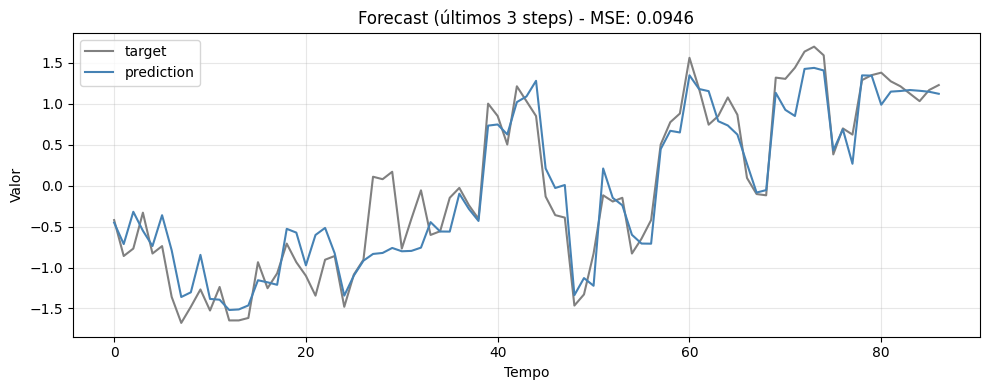

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(target_forecast.flatten(), label='target', color='gray')
plt.plot(recon_forecast.flatten(), label='prediction', color='steelblue')
plt.title(f"Forecast (últimos {target_forecast.shape[1]} steps) - MSE: {mse:.4f}")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
